In [ ]:
# Unzipping the Challenge Dataset
!unzip -q '/content/Challenge_Dataset.zip'

###Data Processing

In [ ]:
# Importing Libraries for Processing
import cv2
from google.colab.patches import cv2_imshow
import os
import random
import imutils
import numpy as np

In [ ]:
# Training Data Pre-Processing & Augmentation
train_images, train_masks = [], []
directory = '/content/Challenge_Dataset/Images/Train'
directory2 = '/content/Challenge_Dataset/Masks/Train'
for image_name, mask_name in zip(os.listdir(directory),os.listdir(directory2)):
    file_path = os.path.join(directory, image_name)
    file_path2 = os.path.join(directory2, mask_name)
    image = cv2.imread(file_path) # convert image to pixels
    image2 = cv2.resize(image,(128,128)) # resizing 2d pixel grid
    image3 = image2/255.0 # normalize pixel values to 0-1
    a = random.choice([0,1,-1]) 
    image4 = cv2.flip(image3,a) # flip horizontally, vertically, or both
    b = random.choice(range(1,360)) # choose random angle from 1 to 359
    image5 = imutils.rotate(image3,b) # rotation by the chosen random angle
    train_images.extend([image3,image4,image5])
    mask = cv2.imread(file_path2) # convert mask to pixels
    mask2 = cv2.resize(mask,(128,128)) # resizing 2d pixel grid
    mask3 = mask2/255.0 # normalize pixel values to 0-1
    mask4 = cv2.flip(mask3,a) # flip along the axis same as for image
    mask5 = imutils.rotate(mask3,b) # rotate by the angle same as for image
    train_masks.extend([mask3,mask4,mask5])

In [ ]:
x_train = np.array(train_images)
del train_images
y_train = np.array(train_masks)
del train_masks

In [ ]:
# Validation Data Pre-Processing & Augmentation
val_images, val_masks = [], []
directory3 = '/content/Challenge_Dataset/Images/Validation'
directory4 = '/content/Challenge_Dataset/Masks/Validation'
for image_name, mask_name in zip(os.listdir(directory3),os.listdir(directory4)):
    file_path = os.path.join(directory3, image_name)
    file_path2 = os.path.join(directory4, mask_name)
    image = cv2.imread(file_path) # convert image to pixels
    image2 = cv2.resize(image,(128,128)) # resizing 2d pixel grid
    image3 = image2/255.0 # normalize pixel values to 0-1
    a = random.choice([0,1,-1]) 
    image4 = cv2.flip(image3,a) # flip horizontally, vertically, or both
    b = random.choice(range(1,360)) # choose random angle from 1 to 359
    image5 = imutils.rotate(image3,b) # rotation by the chosen random angle
    val_images.extend([image3,image4,image5])
    mask = cv2.imread(file_path2) # convert mask to pixels
    mask2 = cv2.resize(mask,(128,128)) # resizing 2d pixel grid
    mask3 = mask2/255.0 # normalize pixel values to 0-1
    mask4 = cv2.flip(mask3,a) # flip along the axis same as for image
    mask5 = imutils.rotate(mask3,b) # rotate by the angle same as for image
    val_masks.extend([mask3,mask4,mask5])

In [ ]:
x_val = np.array(val_images)
del val_images
y_val = np.array(val_masks)
del val_masks

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((3000, 128, 128, 3),
 (3000, 128, 128, 3),
 (600, 128, 128, 3),
 (600, 128, 128, 3))

###Architecture

In [ ]:
# Imporying Libraries for building the network
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
# A residual block as an encoder
def encoder_block(x, n_filters): # ResBlock
    fx = layers.Conv2D(n_filters, 3, padding = "same")(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.ReLU()(fx)
    fx = layers.Conv2D(n_filters, 3, padding = "same")(fx)
    fx = layers.BatchNormalization()(fx)
    out = layers.Add()([x,fx])
    out = layers.ReLU()(out)
    return out

In [ ]:
# A convolution block with 3 convolutions (Conv2D+BN+ReLU)
def convolution_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(n_filters, 3, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

In [ ]:
# A decoder block (concatenation + convolution block + upsampling)
def decoder_block(x, conv_features, n_filters):
    x = layers.concatenate([x, conv_features])
    x = convolution_block(x, n_filters)
    x = layers.UpSampling2D(2,interpolation='bilinear')(x)
    return x

In [ ]:
# Single convolution encoder block (Conv2D+BN+ReLU)
def CBRM(x, n_filters):
  x = layers.Conv2D(n_filters, 3, padding = "same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  return x

In [ ]:
# Single convolution decoder block (Concatenation+Conv2D+BN+ReLU+Upsampling)
def CBRU(x, conv_features, n_filters):
  x = layers.concatenate([x,conv_features])
  x = layers.Conv2D(n_filters, 3, padding = "same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.UpSampling2D(2,interpolation='bilinear')(x)
  return x

In [ ]:
# Residual Refinement Module - A simple U-Net
def refunet(x):
  rx = layers.Conv2D(64, 3, padding = "same")(x)
  r1 = CBRM(rx,64)
  rx = layers.MaxPool2D(2)(r1)
  r2 = CBRM(rx,64)
  rx = layers.MaxPool2D(2)(r2)
  r3 = CBRM(rx,64)
  rx = layers.MaxPool2D(2)(r3)
  r4 = CBRM(rx,64)
  rx = layers.MaxPool2D(2)(r4)
  rx = layers.Conv2D(64, 3, padding = "same")(rx)
  rx = layers.BatchNormalization()(rx)
  rx = layers.ReLU()(rx)
  rx = layers.UpSampling2D(2,interpolation='bilinear')(rx)
  s4 = CBRU(rx,r4,64)
  s3 = CBRU(s4,r3,64)
  s2 = CBRU(s3,r2,64)
  sx = layers.concatenate([s2,r1])
  sx = layers.Conv2D(64, 3, padding = "same")(sx)
  sx = layers.BatchNormalization()(sx)
  s1 = layers.ReLU()(sx)
  residual = layers.Conv2D(3, 1, padding = "same")(s1)
  out = layers.Add()([x,residual])
  return out

In [ ]:
# Generate output mask at each decoding layer
def sideoutput(x, up_factor):
  x = layers.Conv2D(3, 1, padding = "same")(x)
  x = layers.UpSampling2D(up_factor, interpolation='bilinear')(x) # upsampling to output space
  x = layers.Activation('sigmoid')(x)
  return x

Network is based on https://arxiv.org/abs/2101.04704, available in pytorch at https://github.com/xuebinqin/BASNet

In [ ]:
# Boundary Aware Segmentation Network - Main Model (5 encoders + bottleneck + 5 decoders)
def BASNet():
  resnet_model = ResNet50(include_top = False, input_shape = (128,128,3)) # pre-trained resnet50 model
  h1 = resnet_model.layers[38].output # encoder 1
  h2 = resnet_model.layers[80].output # encoder 2
  h3 = resnet_model.layers[142].output # encoder 3
  h4 = resnet_model.layers[-1].output # encoder 4
  hx = layers.MaxPool2D(2)(h4)                     
  h5 = encoder_block(hx,2048) # encoder 5
  hb = convolution_block(h5,2048) # bottleneck
  db = sideoutput(hb,64)
  hd5 = decoder_block(hb,h5,2048) # decoder 5
  d5 = sideoutput(hd5,32)
  hd4 = decoder_block(hd5,h4,1024) # decoder 4
  d4 = sideoutput(hd4,16)
  hd3 = decoder_block(hd4,h3,512) # decoder 3
  d3 = sideoutput(hd3,8)
  hd2 = decoder_block(hd3,h2,256) # decoder 2
  d2 = sideoutput(hd2,4)
  hy = layers.concatenate([hd2,h1])
  hy = convolution_block(hy,64)
  hd1 = layers.UpSampling2D(4,interpolation='bilinear')(hy) # decoder 1
  d1 = layers.Conv2D(3, 1, padding="same")(hd1)
  d1out = layers.Activation('sigmoid')(d1)
  dout = refunet(d1)
  out = layers.Activation('sigmoid')(dout)
  basnet_model = tf.keras.Model(inputs = resnet_model.inputs, outputs = [out,d1out,d2,d3,d4,d5,db])
  return basnet_model

In [ ]:
mynet_model = BASNet()
mynet_model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization

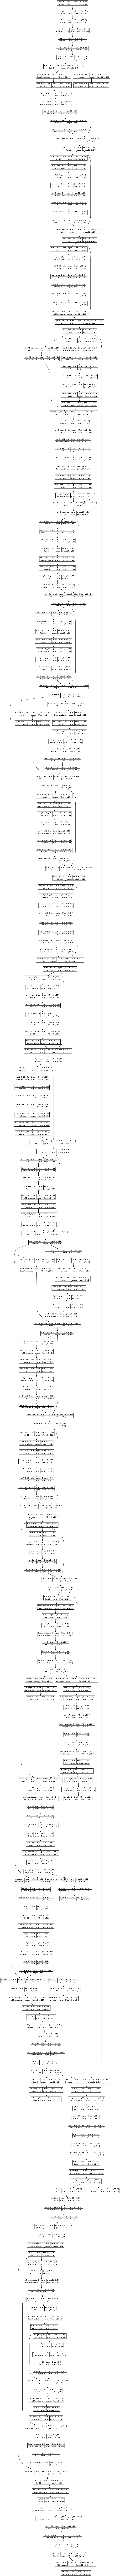

In [ ]:
tf.keras.utils.plot_model(mynet_model, show_shapes=True)

###Training

In [ ]:
from keras import backend as K

# T = True, F = False, P = Positives, N = Negatives

def recall(y_true, y_pred): # calculate recall = TP/(TP+FN)
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (actual_positives + K.epsilon())
  return recall

def precision(y_true, y_pred): # calculate precision = TP/(TP+FP)
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1score(y_true, y_pred): # calculate F1 Score = Dice Coefficient = 2PR/(P+R)
  P = precision(y_true, y_pred)
  R = recall(y_true, y_pred)
  return 2*((P*R)/(P+R+K.epsilon()))

def iouloss(y_true, y_pred):  
  dice = f1score(y_true, y_pred)
  iou = dice/(2-dice) # IoU = Intersection Over Union = F1/(2-F1)
  ioul = 1 - iou # calculate IoU Loss = Jaccard Loss = 1 - IoU
  return ioul

def ssim_loss(y_true, y_pred):
  ssim = tf.image.ssim(y_true, y_pred, 1) # SSIM = Structural Similarity Index Measure
  ssiml = 1 - tf.reduce_mean(ssim) # SSIM Loss = 1 - SSIM
  return ssiml

def custom_loss(y_true, y_pred):
  ssim = ssim_loss(y_true, y_pred)
  iou = iouloss(y_true, y_pred)
  l = tf.keras.losses.BinaryCrossentropy() # Binary Cross-Entropy Loss
  bce = l(y_true, y_pred)
  return ssim + iou + bce

In [ ]:
# calculate loss between predicted output at a layer and true mask, sum of the losses for the layers (i.e. equal weights) as the final loss term
losses = {"activation_6": custom_loss,	"activation_5": custom_loss, "activation_4": custom_loss, "activation_3": custom_loss, "activation_2": custom_loss, "activation_1": custom_loss, "activation": custom_loss}
lossWeights = {"activation_6": 1, "activation_5": 1, "activation_4": 1, "activation_3": 1, "activation_2": 1, "activation_1": 1, "activation": 1}
# Adam Optimisation with default settings, record the main metric F1 Score along with accuracy
mynet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=losses, loss_weights=lossWeights, metrics=['acc',f1score])

In [ ]:
# True Mask is the true label for all layer outputs
y_train_all = {"activation_6": y_train, "activation_5": y_train, "activation_4": y_train, "activation_3": y_train, "activation_2": y_train, "activation_1": y_train, "activation": y_train}
y_val_all = {"activation_6": y_val, "activation_5": y_val, "activation_4": y_val, "activation_3": y_val, "activation_2": y_val, "activation_1": y_val, "activation": y_val}
# Train for 500 epochs with batch size as 8
model_history = mynet_model.fit(x = x_train, y = y_train_all, epochs = 500, validation_data = (x_val, y_val_all), batch_size=8)

Epoch 1/500
375/375 [==============================] - 309s 754ms/step - loss: 13.7142 - activation_6_loss: 1.7919 - activation_5_loss: 1.8260 - activation_4_loss: 1.7277 - activation_3_loss: 1.7197 - activation_2_loss: 1.7838 - activation_1_loss: 2.4296 - activation_loss: 2.4355 - activation_6_acc: 0.1528 - activation_6_f1score: 0.3448 - activation_5_acc: 0.4228 - activation_5_f1score: 0.3874 - activation_4_acc: 0.3807 - activation_4_f1score: 0.3795 - activation_3_acc: 0.3145 - activation_3_f1score: 0.4167 - activation_2_acc: 0.2854 - activation_2_f1score: 0.3760 - activation_1_acc: 0.3337 - activation_1_f1score: 0.0033 - activation_acc: 0.3422 - activation_f1score: 0.0041 - val_loss: 13.4515 - val_activation_6_loss: 1.6794 - val_activation_5_loss: 1.7005 - val_activation_4_loss: 1.7252 - val_activation_3_loss: 1.7230 - val_activation_2_loss: 1.7712 - val_activation_1_loss: 2.4349 - val_activation_loss: 2.4174 - val_activation_6_acc: 0.0328 - val_activation_6_f1score: 0.4830 - val_act

KeyboardInterrupt: ignored

In [ ]:
import pickle
filename = 'MyNet_Model.sav'
pickle.dump(mynet_model, open(filename, 'wb'))  # save the model

OverflowError: ignored

In [ ]:
mynet_model.save('/content/mymodel/')  # save the model

In [ ]:
mc = keras.callbacks.ModelCheckpoint('model{epoch:03d}.h5')  # save the model weights at every epoch

In [ ]:
# True Mask is the true label for all layer outputs
y_train_all = {"activation_6": y_train, "activation_5": y_train, "activation_4": y_train, "activation_3": y_train, "activation_2": y_train, "activation_1": y_train, "activation": y_train}
y_val_all = {"activation_6": y_val, "activation_5": y_val, "activation_4": y_val, "activation_3": y_val, "activation_2": y_val, "activation_1": y_val, "activation": y_val}
# Train for 50 epochs with batch size as 8
model_history = mynet_model.fit(x = x_train, y = y_train_all, epochs = 50, validation_data = (x_val, y_val_all), batch_size=8, callbacks=[mc])

Epoch 1/50
375/375 [==============================] - 333s 817ms/step - loss: 13.4381 - activation_6_loss: 1.7867 - activation_5_loss: 1.7657 - activation_4_loss: 1.7396 - activation_3_loss: 1.7182 - activation_2_loss: 1.7603 - activation_1_loss: 2.3325 - activation_loss: 2.3351 - activation_6_acc: 0.2340 - activation_6_f1score: 0.3179 - activation_5_acc: 0.6456 - activation_5_f1score: 0.4026 - activation_4_acc: 0.5046 - activation_4_f1score: 0.3813 - activation_3_acc: 0.3025 - activation_3_f1score: 0.4064 - activation_2_acc: 0.3266 - activation_2_f1score: 0.3816 - activation_1_acc: 0.3327 - activation_1_f1score: 0.0021 - activation_acc: 0.3513 - activation_f1score: 0.0021 - val_loss: 13.4873 - val_activation_6_loss: 1.7314 - val_activation_5_loss: 1.7452 - val_activation_4_loss: 1.7024 - val_activation_3_loss: 1.7286 - val_activation_2_loss: 1.7813 - val_activation_1_loss: 2.3867 - val_activation_loss: 2.4118 - val_activation_6_acc: 0.1137 - val_activation_6_f1score: 0.4651 - val_acti

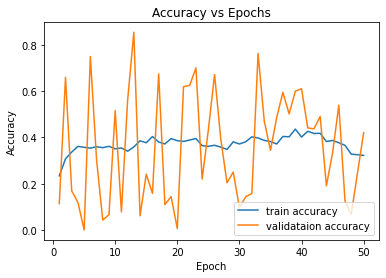

In [ ]:
epochs = range(1,51)
acc = model_history.history["activation_6_acc"]
val_acc = model_history.history["val_activation_6_acc"]
plt.plot(epochs, acc, label="train accuracy")
plt.plot(epochs, val_acc, label="validataion accuracy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

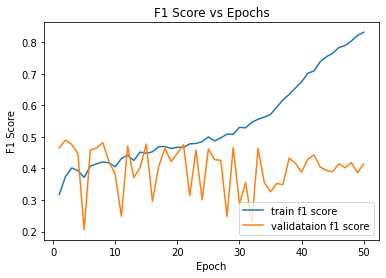

In [ ]:
# The loss function essentially trains the model to maximise F1 Score (not accuracy) as IoU and F1 are closely related
epochs = range(1,51)
f1 = model_history.history["activation_6_f1score"]
val_f1 = model_history.history["val_activation_6_f1score"]
plt.plot(epochs, f1, label="train f1 score")
plt.plot(epochs, val_f1, label="validataion f1 score")
plt.title("F1 Score vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend(loc="lower right")

From this plot it seems the model is stilling undergoing training, and hasn't learnt optimum weights which can generalise the model to predict on new data (as the train f1 score keeps on increasing with epochs while validation f1 score in fact marginally decreases)

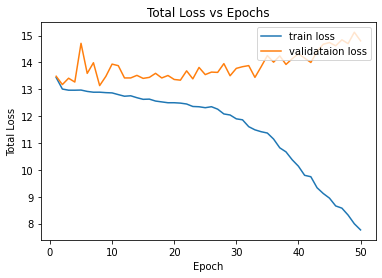

In [ ]:
epochs = range(1,51)
tot_loss = model_history.history["loss"]
tot_val_loss = model_history.history["val_loss"]
plt.plot(epochs, tot_loss, label="train loss")
plt.plot(epochs, tot_val_loss, label="validataion loss")
plt.title("Total Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.legend(loc="upper right")

Similar observation here: the training loss keeps on decreasing. However, the validation loss keeps on increasing which isn't desirable.

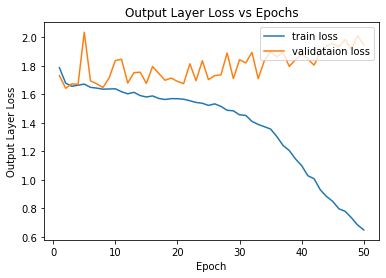

In [ ]:
epochs = range(1,51)
out_loss = model_history.history["activation_6_loss"]
out_val_loss = model_history.history["val_activation_6_loss"]
plt.plot(epochs, out_loss, label="train loss")
plt.plot(epochs, out_val_loss, label="validataion loss")
plt.title("Output Layer Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Output Layer Loss")
plt.legend(loc="upper right")

The earlier plot was for total loss vs epochs. Whereas this plot is the loss between model prediction (final layer output) and true mask.

In [ ]:
mynet_model.save('/content/MyModel/') # save the model
!zip -r '/content/MyModel.zip' '/content/MyModel' # zip the saved model folder

  adding: content/MyModel/ (stored 0%)
  adding: content/MyModel/saved_model.pb (deflated 92%)
  adding: content/MyModel/assets/ (stored 0%)
  adding: content/MyModel/variables/ (stored 0%)
  adding: content/MyModel/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/MyModel/variables/variables.index (deflated 82%)
  adding: content/MyModel/keras_metadata.pb (deflated 95%)


In [ ]:
#!unzip -q '/content/MyModel.zip' # unzip the saved folder and load the trained model for testing
#model = keras.models.load_model('/content/MyModel',custom_objects={'f1score':f1score,'losses':losses,'lossWeights':lossWeights,'custom_loss':custom_loss})

As an example the first train and validation images and masks are taken as the testing set

In [ ]:
image = cv2.imread('/content/Challenge_Dataset/Images/Train/c_0.jpg')
image = cv2.resize(image,(128,128))
test_image = np.reshape(image,(1,128,128,3))
image2 = cv2.imread('/content/Challenge_Dataset/Images/Validation/c_2.jpg')
image2 = cv2.resize(image2,(128,128))
test_image2 = np.reshape(image2,(1,128,128,3))
test_set = np.vstack((test_image,test_image2))
test_set.shape

(2, 128, 128, 3)

In [ ]:
TI = tf.convert_to_tensor(test_set, dtype=tf.float32)

In [ ]:
mask = cv2.imread('/content/Challenge_Dataset/Masks/Train/c_0.png')
mask = cv2.resize(mask,(128,128))
test_mask = np.reshape(mask,(1,128,128,3))
mask2 = cv2.imread('/content/Challenge_Dataset/Masks/Validation/c_2.png')
mask2 = cv2.resize(mask2,(128,128))
test_mask2 = np.reshape(mask2,(1,128,128,3))
test_set_m = np.vstack((test_mask,test_mask2))
test_set_m.shape

(2, 128, 128, 3)

In [ ]:
TM = tf.convert_to_tensor(test_set_m, dtype=tf.float32)

In [ ]:
pred = mynet_model.predict(TI)[0]

1/1 [==============================] - 0s 26ms/step


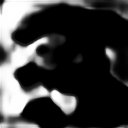

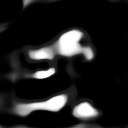

In [ ]:
for mask in pred: # display mask predictions on test set
    cv2_imshow(cv2.cvtColor(mask*255, cv2.COLOR_BGR2GRAY))

In [ ]:
metrics = mynet_model.evaluate(TI,TM) # evaluate performance metrics on test set

1/1 [==============================] - 6s 6s/step - loss: -inf - activation_6_loss: -inf - activation_5_loss: -inf - activation_4_loss: -inf - activation_3_loss: -4083.7046 - activation_2_loss: -inf - activation_1_loss: -824.3973 - activation_loss: -852.2518 - activation_6_acc: 1.0000 - activation_6_f1score: 0.4685 - activation_5_acc: 1.0000 - activation_5_f1score: 0.4661 - activation_4_acc: 0.8576 - activation_4_f1score: 0.0162 - activation_3_acc: 0.8623 - activation_3_f1score: 0.4349 - activation_2_acc: 0.9767 - activation_2_f1score: 0.0000e+00 - activation_1_acc: 1.0000 - activation_1_f1score: 0.3171 - activation_acc: 0.3227 - activation_f1score: 0.3171


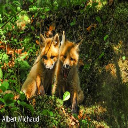

In [ ]:
cv2_imshow(test_image[0])

In [ ]:
y_hat = mynet_model.predict(test_image)[0]

1/1 [==============================] - 0s 25ms/step


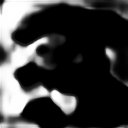

In [ ]:
cv2_imshow(cv2.cvtColor(y_hat[0]*255, cv2.COLOR_BGR2GRAY))

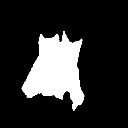

In [ ]:
cv2_imshow(test_mask[0])

###Smaller Model

In [ ]:
def BAS2Net():
  resnet_model = ResNet50(include_top = False, input_shape = (128,128,3))
  resnet_model.trainable = False
  h1 = resnet_model.layers[38].output # encoder 1
  h2 = resnet_model.layers[80].output # encoder 2
  h3 = resnet_model.layers[142].output # encoder 3
  h4 = resnet_model.layers[-1].output # encoder 4                    
  hb = convolution_block(h4,2048) # bottleneck
  db = sideoutput(hb,32)
  hd4 = decoder_block(hb,h4,1024) # decoder 4
  d4 = sideoutput(hd4,16)
  hd3 = decoder_block(hd4,h3,512) # decoder 3
  d3 = sideoutput(hd3,8)
  hd2 = decoder_block(hd3,h2,256) # decoder 2
  d2 = sideoutput(hd2,4)
  hy = layers.concatenate([hd2,h1])
  hy = convolution_block(hy,64)
  hd1 = layers.UpSampling2D(4,interpolation='bilinear')(hy) # decoder 1
  d1 = layers.Conv2D(3, 1, padding="same")(hd1)
  d1out = layers.Activation('sigmoid')(d1)
  dout = refunet(d1)
  out = layers.Activation('sigmoid')(dout)
  bas2net_model = tf.keras.Model(inputs = resnet_model.inputs, outputs = [out,d1out,d2,d3,d4,db])
  return bas2net_model

In [ ]:
my2net_model = BAS2Net()
my2net_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

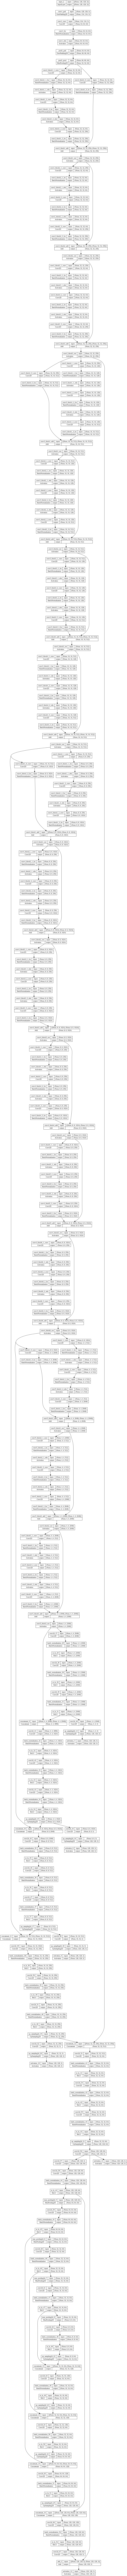

In [ ]:
tf.keras.utils.plot_model(my2net_model, show_shapes=True)

In [ ]:
losses = {"activation_12": custom_loss,	"activation_11": custom_loss, "activation_10": custom_loss, "activation_9": custom_loss, "activation_8": custom_loss, "activation_7": custom_loss}
lossWeights = {"activation_12": 1, "activation_11": 1, "activation_10": 1, "activation_9": 1, "activation_8": 1, "activation_7": 1}
my2net_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=losses, loss_weights=lossWeights, metrics=['acc',f1score])

In [ ]:
del mynet_model

In [ ]:
y_train_all = {"activation_12": y_train, "activation_11": y_train, "activation_10": y_train, "activation_9": y_train, "activation_8": y_train, "activation_7": y_train}
y_val_all = {"activation_12": y_val, "activation_11": y_val, "activation_10": y_val, "activation_9": y_val, "activation_8": y_val, "activation_7": y_val}
model2_history = my2net_model.fit(x = x_train, y = y_train_all, epochs = 10, validation_data = (x_val, y_val_all), batch_size=8)

Epoch 1/10
375/375 [==============================] - 147s 362ms/step - loss: 10.4876 - activation_12_loss: 1.7534 - activation_11_loss: 1.7912 - activation_10_loss: 1.7235 - activation_9_loss: 1.7010 - activation_8_loss: 1.7596 - activation_7_loss: 1.7588 - activation_12_acc: 0.3632 - activation_12_f1score: 0.3386 - activation_11_acc: 0.5607 - activation_11_f1score: 0.4219 - activation_10_acc: 0.2883 - activation_10_f1score: 0.3799 - activation_9_acc: 0.2867 - activation_9_f1score: 0.4265 - activation_8_acc: 0.3671 - activation_8_f1score: 0.3824 - activation_7_acc: 0.3950 - activation_7_f1score: 0.3828 - val_loss: 10.7012 - val_activation_12_loss: 1.8568 - val_activation_11_loss: 1.6897 - val_activation_10_loss: 1.7671 - val_activation_9_loss: 1.7061 - val_activation_8_loss: 1.7811 - val_activation_7_loss: 1.9004 - val_activation_12_acc: 0.0462 - val_activation_12_f1score: 0.2022 - val_activation_11_acc: 0.1969 - val_activation_11_f1score: 0.4386 - val_activation_10_acc: 0.5102 - val_

In [ ]:
my2net_model.save('/content/My2Model/')
!zip -r '/content/My2Model.zip' '/content/My2Model'

  adding: content/My2Model/ (stored 0%)
  adding: content/My2Model/saved_model.pb (deflated 92%)
  adding: content/My2Model/assets/ (stored 0%)
  adding: content/My2Model/variables/ (stored 0%)
  adding: content/My2Model/variables/variables.data-00000-of-00001 (deflated 21%)
  adding: content/My2Model/variables/variables.index (deflated 81%)
  adding: content/My2Model/keras_metadata.pb (deflated 95%)
